# Polyak averaging

Let's try this out. My method for implementing this in TensorFlow started from a blog post here: http://ruishu.io/2017/11/22/ema/ but is updated to work with newer TF versions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import sklearn.decomposition

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Load the dataset

Let's get MNISTy.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [73]:
tf.reset_default_graph()

kernel = tf.constant(np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
]), dtype=tf.float32)

x = tf.placeholder(tf.float32, [784,])
img = tf.reshape(x, [1, 28, 28, 1])
kern = tf.reshape(kernel, [3, 3, 1, 1])

conv = tf.nn.conv2d(img, kern, strides=[1, 1, 1, 1], padding="SAME")
conv = tf.squeeze(conv)

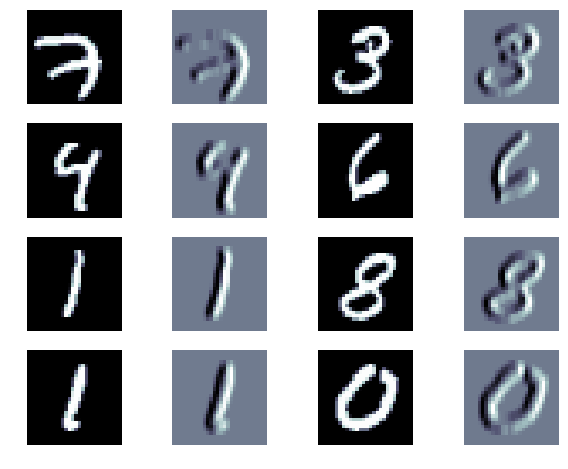

In [74]:
figsize(10, 8)
with tf.Session() as sess:
    for i in range(8):
        im = mnist.train.images[i,:]
        plt.subplot(4, 4, 2*i+1)
        plt.imshow(im.reshape((28,28)), cmap=plt.cm.bone, interpolation="none")
        plt.axis("off")
    
        plt.subplot(4, 4, 2*(i+1))
        plt.imshow(sess.run(conv, feed_dict={x:im}), cmap=plt.cm.bone, interpolation="none")
        plt.axis("off")

In [71]:
tf.reset_default_graph()

kernel = tf.constant(np.array([
    [[1,0,-1],
    [1,0,-1],
    [1,0,-1]],
    [[-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]],
    [[1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]],
]), dtype=tf.float32)

x = tf.placeholder(tf.float32, [784,])
img = tf.reshape(x, [1, 28, 28, 1])
kern = tf.reshape(kernel, [3, 3, 1, 3])

conv = tf.nn.conv2d(img, kern, strides=[1, 1, 1, 1], padding="SAME")
maxpool = tf.nn.max_pool(conv, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
maxpool = tf.squeeze(maxpool)

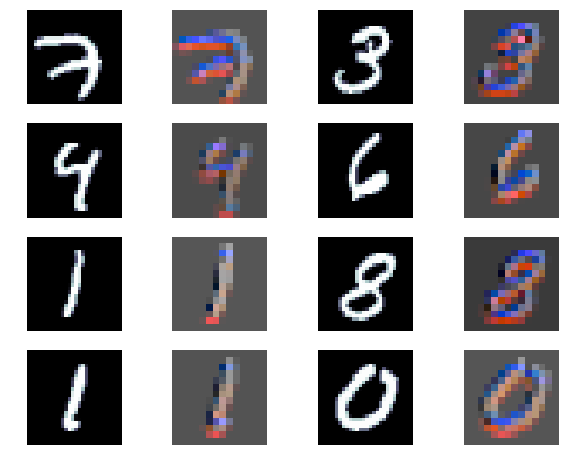

In [72]:
figsize(10, 8)
with tf.Session() as sess:
    for i in range(8):
        im = mnist.train.images[i,:]
        plt.subplot(4, 4, 2*i+1)
        plt.imshow(im.reshape((28,28)), cmap=plt.cm.bone, interpolation="none")
        plt.axis("off")
    
        plt.subplot(4, 4, 2*(i+1))
        features = sess.run(maxpool, feed_dict={x:im})
        features -= features.min()
        features /= features.max()
        plt.imshow(features, interpolation="none")
        plt.axis("off")

In [94]:
tf.reset_default_graph()

kernel = tf.constant(np.array([
    [[1,0,-1],
    [1,0,-1],
    [1,0,-1]],
    [[-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]],
    [[1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]],
]), dtype=tf.float32)

x = tf.placeholder(tf.float32, [None,784])
y_ = tf.placeholder(tf.int32, [None,])
y_oh = tf.one_hot(y_, 10)

img = tf.reshape(x, [-1, 28, 28, 1])
print("img:", img.get_shape())

conv1 = tf.layers.conv2d(img, 4, [3, 3], padding="same")
pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, padding="same")
print("pool1:", pool1.get_shape())

conv2 = tf.layers.conv2d(pool1, 16, [3, 3], padding="same")
pool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding="same")
print("pool2:", pool2.get_shape())
flat = tf.layers.flatten(pool2)
print("flat:", flat.get_shape())

logits = tf.layers.dense(flat, 10)
probs = tf.nn.softmax(logits)
predictions = tf.argmax(logits, 1, output_type=tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_), tf.float32))

loss = tf.losses.softmax_cross_entropy(y_oh, logits)
optimizer = tf.train.RMSPropOptimizer(1e-3)
train_op = optimizer.minimize(loss)

img: (?, 28, 28, 1)
pool1: (?, 14, 14, 4)
pool2: (?, 7, 7, 16)
flat: (?, 784)


In [97]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(250):
        im, lab = mnist.train.next_batch(250)
        sess.run(train_op, feed_dict={x:im, y_:lab})
        if e % 10 == 0:
            acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
            print("%s test accuracy: %s"%(e,acc))
            
    filters = sess.run([img, pool1, pool2], feed_dict={x:mnist.train.images[:10,:]})

0 test accuracy: 0.0975
10 test accuracy: 0.0996
20 test accuracy: 0.1026
30 test accuracy: 0.1071
40 test accuracy: 0.1173
50 test accuracy: 0.1434
60 test accuracy: 0.2108
70 test accuracy: 0.2969
80 test accuracy: 0.4058
90 test accuracy: 0.5805
100 test accuracy: 0.6958
110 test accuracy: 0.7649
120 test accuracy: 0.7715
130 test accuracy: 0.8198
140 test accuracy: 0.8453
150 test accuracy: 0.8592
160 test accuracy: 0.8757
170 test accuracy: 0.8858
180 test accuracy: 0.8902
190 test accuracy: 0.8961
200 test accuracy: 0.8996
210 test accuracy: 0.9015
220 test accuracy: 0.9046
230 test accuracy: 0.9111
240 test accuracy: 0.9143


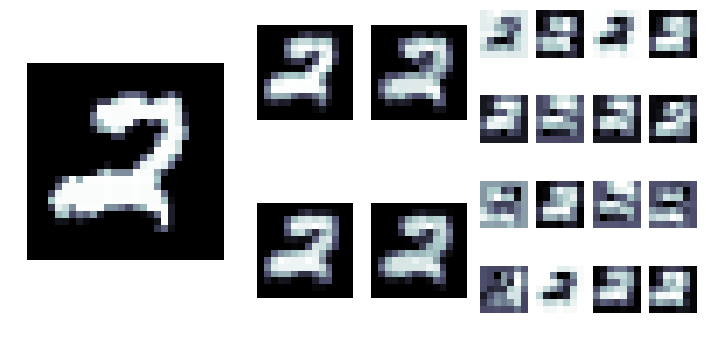

In [116]:
i = 7
figsize(12, 6)

plt.subplot(1, 3, 1)
#plt.figure()
plt.imshow(filters[0][i,:,:,0], cmap=plt.cm.bone, interpolation="none")
plt.axis("off")

#plt.figure()
for j in range(4):
    plt.subplot(2, 6, [3, 4, 9, 10][j])
    plt.imshow(filters[1][i,:,:,j], cmap=plt.cm.bone, interpolation="none")
    plt.axis("off");
    
for j in range(16):
    plt.subplot(4, 12, [9, 10, 11, 12, 21, 22, 23, 24, 33, 34, 35, 36,
                       45, 46, 47, 48][j])
    plt.imshow(filters[2][i,:,:,j], cmap=plt.cm.bone, interpolation="none")
    plt.axis("off");